# Notebook for making a CO$_2$ emissions file for emissions-driven CESM2

### First load the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy import optimize as opt

import pandas as pd
import xarray as xr

import netCDF4 as nc4

import shutil
import datetime
import subprocess

### define functions for a Gaussian and the first derivative of a Gaussian (these are the cumulatieve and annual CO$_2$ emissions timeseries)

In [2]:
def gauss(t,a,b,c):
    y = a*np.exp(-((t-b)**2.)/(2*c**2))
    return(y)

def gaussderiv(t,a,b,c):
    y = (a*(b-t)*np.exp(-((b-t)**2.)/(2*c**2.)))/(c**2.)
    return(y)

### Make variables for the intended globally integrated CO$_2$ emissions and cumulative emissions, and plot.

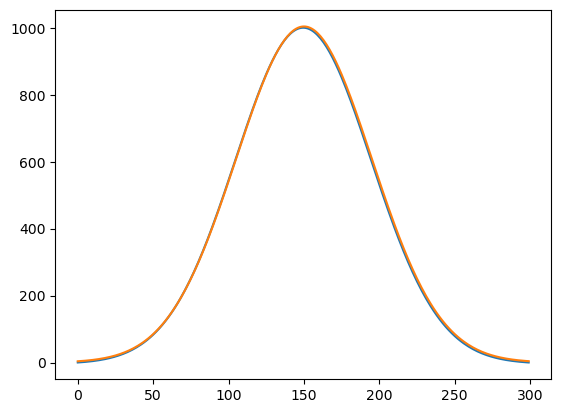

In [3]:
t = np.arange(300)
y = gaussderiv(t,1004,150,45)
yy = gauss(t,1004,150,45)

plt.plot(t,y.cumsum())
plt.plot(t,yy)


Text(0, 0.5, 'Annual Emissions (PgC)')

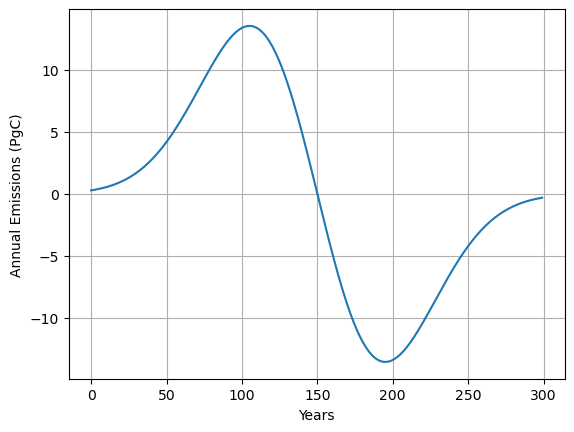

In [6]:
# plot emissions
plt.plot(t,y)
plt.grid()
plt.xlabel('Years')
plt.ylabel('Annual Emissions (PgC)')

### Open a file containing gridcell areas for the resolution being used.

In [3]:
mapfile = xr.open_dataset('areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
areas = mapfile['areacella'].sum()
global_gridcell_integrated_area = float(areas.data)

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


### Take a pre-existing CESM CO$_2$ emissions file, and copy it with a new filename.

In [4]:
fname_base = 'emissions-cmip6_CO2_anthro_surface_175001-201512_fv_0.9x1.25_c20181011.nc'

datestring = str(datetime.date.today().year * 10000 + datetime.date.today().month * 100 + datetime.date.today().day)
fname_new = 'emissions_idealized_edrivencdr_000101-031012_fv_0.9x1.25_cdk_'+datestring+'.nc'

shutil.copyfile(fname_base, fname_new)

'emissions_idealized_edrivencdr_000101-031012_fv_0.9x1.25_cdk_20220218.nc'

### Open the newly-created file in read/write mode.

In [5]:
file = nc4.Dataset(fname_new, 'r+')


### Rework the time coordinates in the new file. Since this is an idealized run, start at year 0.

In [6]:
time_firstyear = file.variables['time'][0:12]
time_bnds_firstyear = file.variables['time_bnds'][0:12,:]

In [7]:
nyears_out = 310
ts_out = nyears_out * 12
year_out = np.floor(np.arange(ts_out) / 12)
month_out = np.tile(time_firstyear,nyears_out)
date_out = year_out*365 + month_out

In [8]:
month_out_bnds = np.tile(time_bnds_firstyear,(nyears_out,1))
#month_out_bnds.shape
date_out_bnds = np.tile(year_out, (2,1)).transpose()*365 + month_out_bnds


In [9]:
file.variables['time'][:] = date_out

In [10]:
file.variables['time_bnds'][:] = date_out_bnds

In [11]:
#file.variables['CO2_flux']

### Put the globally-integrated CO$_2$ emissions into a variable

In [12]:
t = date_out / 365.
y = gaussderiv(t,1004,150,45)

In [13]:
y[-120:] = 0.  # pad out the lst ten years with zeros

### Define lat and lon indices

In [14]:
IM = len(file.variables['lon'][:])
JM = len(file.variables['lat'][:])


### Convert the globally-integrated CO$_2$ fluxes (in Pg C / year) to fluxes for each gridcell (in Kg CO$2$ / (m^2 sec))

In [15]:
co2fluxdata = np.tile(y * 1.e12 * (44.01/12.01) / (global_gridcell_integrated_area * 86400. * 365.), (IM,JM,1))  # IM,JM))

In [16]:
co2fluxdata.transpose().shape

(3720, 192, 288)

In [17]:
file.variables['CO2_flux'][:].shape

(3720, 192, 288)

### Put the new CO$_2$ flux data into the netcdf file

In [18]:
file.variables['CO2_flux'][:] = co2fluxdata.transpose()

### Make some changes to the netcdf file metadata.

In [19]:
file.variables['time'].units = 'days since 0001-01-01 00:00:00'

In [20]:
file.data_title = "Idealized emissions-driven CDR experiment, delta T = 300 years, max cumulative emissions = 1000 Pg C." ;
file.data_summary = "idealized data is output of function y = gaussderiv(t,a=1004,b=150,c=45), where gaussderiv function is y = (a*(b-t)*np.exp(-((b-t)**2.)/(2*c**2.)))/(c**2.). Peak value of 1004 Pg rather than 1000 Pg used to compensate for truncated tails."
file.source_files = "netcdf template from emissions-cmip6_CO2_anthro_surface_175001-201512_fv_0.9x1.25_c20181011.nc. script for generating is on https://github.com/ckoven/idealized_emissionsdriven_cdr_scenario. gridcell areas from areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc"
file.data_creator = "charlie koven, cdkoven@lbl.gov"
file.creation_date = datetime.date.today().isoformat()
file.data_script = "make_idealized_edriven_scenario_forcingfile.ipynb"
file.data_reference = "n/a"

In [21]:
file.close()

### Do some final checks and generate an md5 hash of the file that was just created for provenance tracking purposes.

In [22]:
y.cumsum()[3599]

0.020479102268602667

In [23]:
y.cumsum().argmax()

1799

In [24]:
y.argmax()

1260

In [25]:
#genarate a hash of the output file in case future verification is needed
subprocess.run(['md5', fname_new], stdout=subprocess.PIPE)


CompletedProcess(args=['md5', 'emissions_idealized_edrivencdr_000101-031012_fv_0.9x1.25_cdk_20220218.nc'], returncode=0, stdout=b'MD5 (emissions_idealized_edrivencdr_000101-031012_fv_0.9x1.25_cdk_20220218.nc) = 74bd73ade3fedc4431331cb74fc57535\n')